In [78]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json

In [74]:
gene_to_function = pd.read_csv('gene_to_function.csv')

In [75]:
gene_to_function

,Unnamed: 0,Gene,Function
0,0,A1BG,NaN
1,1,NAT2,Participates in the detoxification of a pletho...
2,2,ADA,Catalyzes the hydrolytic deamination of adenos...
3,3,CDH2,Calcium-dependent cell adhesion protein; prefe...
4,4,AKT3,AKT3 is one of 3 closely related serine/threon...
...,...,...,...
27605,27605,KCNE2,Ancillary protein that assembles as a beta sub...
27606,27606,DGCR2,"Putative adhesion receptor, that could be invo..."
27607,27607,CASP8AP2,Participates in TNF-alpha-induced blockade of ...
27608,27608,ELK2BP,NaN


In [76]:
gene_to_function = gene_to_function.dropna(axis=0)

In [77]:
all_lens = [len(func.split(' ')) for func in list(gene_to_function['Function'])]
sum(all_lens)/len(all_lens)

66.92178835489834

In [85]:
gene_to_function['Dimension 1'] = prot_tsne_results_filtered[:,0]
gene_to_function['Dimension 2'] = prot_tsne_results_filtered[:,1]
gene_to_function = gene_to_function.drop('Unnamed: 0', axis=1)

/tmp/ipykernel_633994/2847784193.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_to_function['Dimension 1'] = prot_tsne_results_filtered[:,0]
/tmp/ipykernel_633994/2847784193.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gene_to_function['Dimension 2'] = prot_tsne_results_filtered[:,1]


In [87]:
gene_to_function.to_csv('gene_embeddings_function.csv')

In [3]:
mapping_file = pd.read_csv('txgnn_idx_name.csv')
mapping_file = mapping_file.sort_values(by='idx')
mapping_file = mapping_file.reset_index(drop=True)


In [21]:
def get_uniprot_function(gene_name):
    """Fetches UniProt function description for a given gene name."""
    url = f"https://rest.uniprot.org/uniprotkb/search?query=(reviewed:true)%20AND%20(organism_id:9606)%20AND%20(gene:{gene_name})"
    response = requests.get(url)
    if response.ok:
        data = json.loads(response.text)
        if data["results"]:
            try:
                function_description = [c for c in data['results'][0]['comments'] if c['commentType'] in ['FUNCTION', 'MISCELLANEOUS']][0]['texts'][0]['value']
                return function_description
            except:
                print(f'{gene_name} have no function comment')
                return None
        else:
            #print(f'{gene_name} not found in UniProt')
            return None
    else:
        return "Error in fetching data"

## Load embeddings

In [115]:
import torch
import pickle
from sklearn.manifold import TSNE

emb_path = '/om/user/tysinger/models/node_emb.pkl'
with open(emb_path, 'rb') as f:
    embeddings = pickle.load(f)

prot_embs = embeddings['disease']

In [116]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
prot_tsne_results = tsne.fit_transform(prot_embs)

In [79]:
df = pd.DataFrame()
df['t-SNE 1'] = prot_tsne_results[:,0]
df['t-SNE 2'] = prot_tsne_results[:,1]
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="t-SNE 1", y="t-SNE 2",
    data=df.loc[gene_to_function.index],
    alpha=0.5,
    s=10
)

NameError: name 'gene_to_function' is not defined

<Figure size 1600x1000 with 0 Axes>

<Axes: xlabel='t-SNE 1', ylabel='t-SNE 2'>

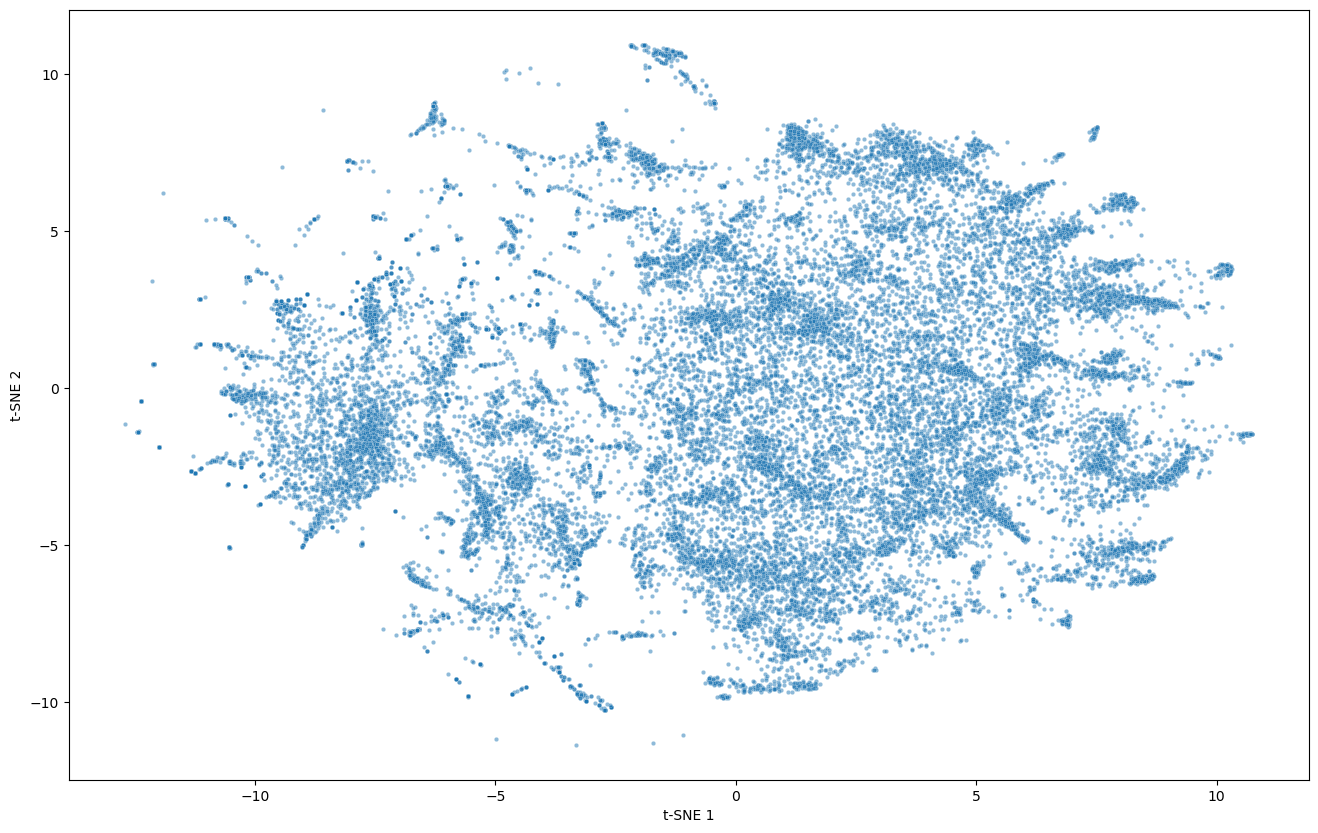

In [92]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="t-SNE 1", y="t-SNE 2",
    data=df,
    alpha=0.5,
    s=10
)

In [80]:
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
prot_tsne_results_filtered = tsne.fit_transform(prot_embs[gene_to_function.index])

<Axes: xlabel='t-SNE 1', ylabel='t-SNE 2'>

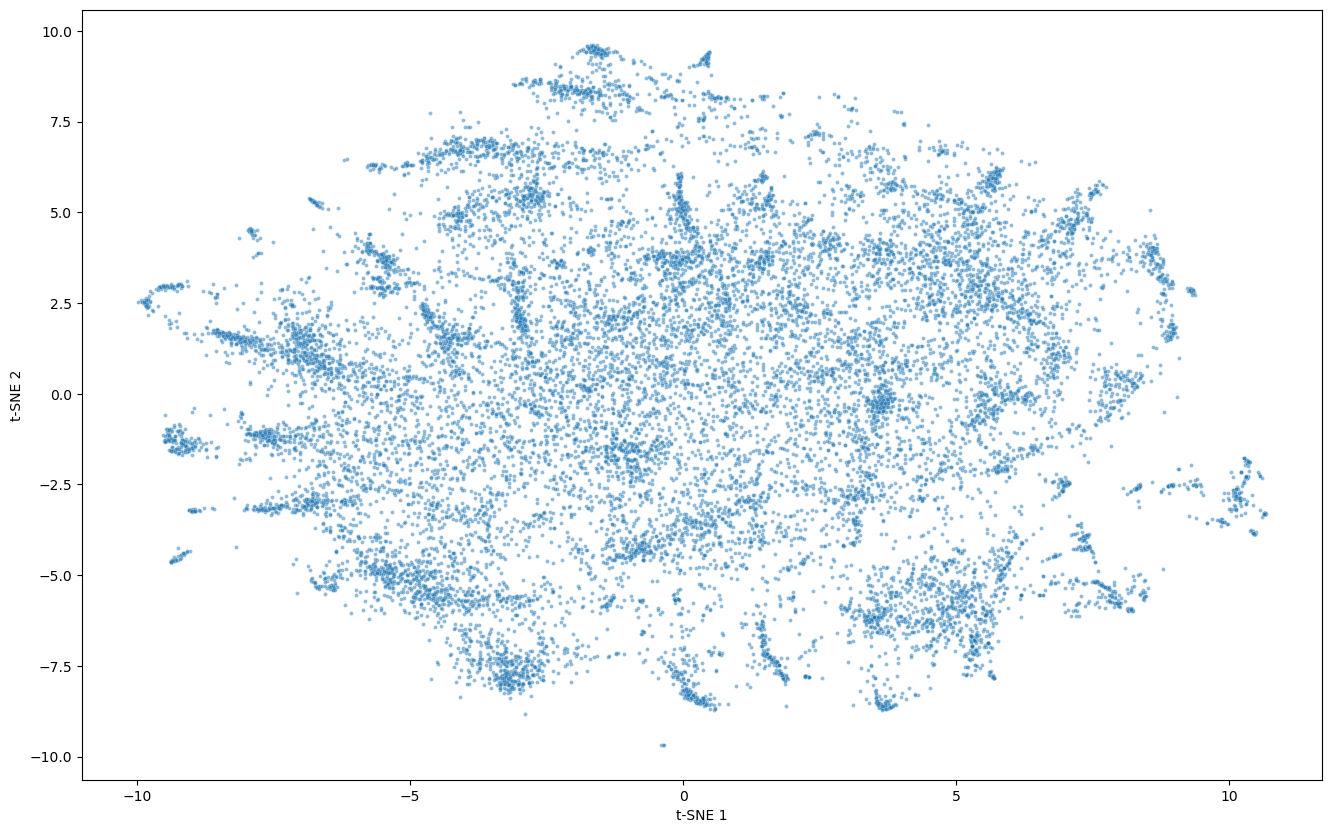

In [93]:
df_filtered = pd.DataFrame()
df_filtered['t-SNE 1'] = prot_tsne_results_filtered[:,0]
df_filtered['t-SNE 2'] = prot_tsne_results_filtered[:,1]
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="t-SNE 1", y="t-SNE 2",
    data=df_filtered,
    alpha=0.5,
    s=8
)

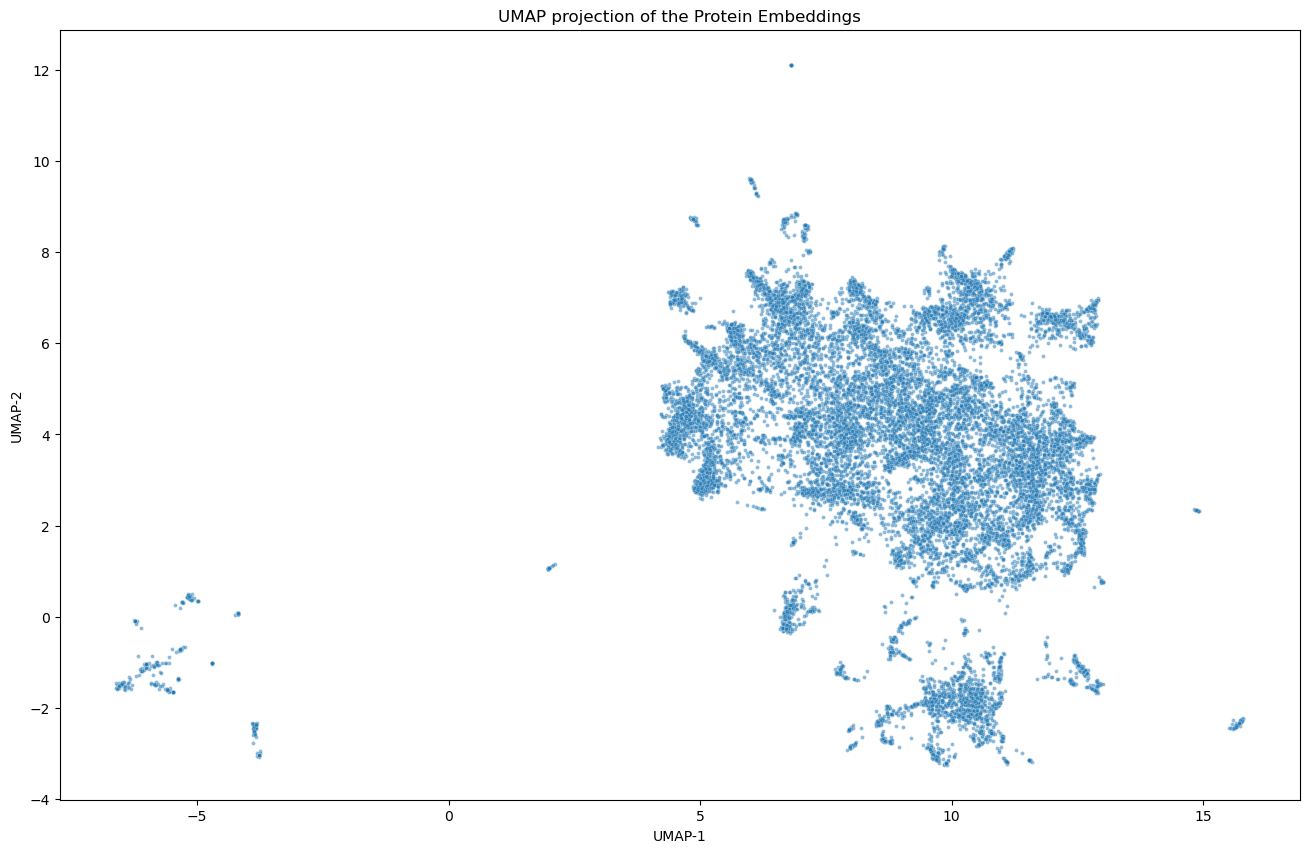

In [96]:
import umap

# Assuming prot_embs[gene_to_function.index] is your data
data = prot_embs[gene_to_function.index]

# Using UMAP for dimensionality reduction
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
umap_results = umap_model.fit_transform(data)

# Creating a DataFrame for the UMAP results
df_filtered_umap = pd.DataFrame()
df_filtered_umap['UMAP-1'] = umap_results[:, 0]
df_filtered_umap['UMAP-2'] = umap_results[:, 1]

# Plotting the results
plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="UMAP-1", y="UMAP-2",
    data=df_filtered_umap,
    alpha=0.5,
    s=8
)
plt.title('UMAP projection of the Protein Embeddings')
plt.show()



### Get drug and disease text

In [18]:
import os
import requests
from tqdm import tqdm
import pandas as pd
import datetime
from txgnn import TxData, TxGNN, TxEval

/home/tysinger/.conda/envs/txgnn_env2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def dataverse_download(url, save_path):
    """dataverse download helper with progress bar
    Args:
        url (str): the url of the dataset
        path (str): the path to save the dataset
    """
    
    if os.path.exists(save_path):
        print('Found local copy...')
    else:
        print("Local copy not detected... Downloading...")
        response = requests.get(url, stream=True)
        total_size_in_bytes= int(response.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
        with open(save_path, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()  

def data_download_wrapper(url, save_path):

    if os.path.exists(save_path):
        print('Found local copy...')
    else:
        dataverse_download(url, save_path)
        print("Done!")

In [6]:
data_path = '/om/user/tysinger/kg/'
data_download_wrapper('https://dataverse.harvard.edu/api/access/datafile/6180619', os.path.join(data_path, 'drug_features.csv'))

Local copy not detected... Downloading...


100%|██████████| 10.0M/10.0M [00:00<00:00, 43.1MiB/s]

Done!


In [94]:
drug_features_df = pd.read_csv(os.path.join(data_path, 'drug_features.csv'), sep='\t')
disease_features_df = pd.read_csv(os.path.join(data_path, 'disease_features.csv'), sep='\t')

In [118]:
drug_features_df = drug_features_df[['node_index', 'description']]
disease_features_df = disease_features_df[['node_index', 'mondo_definition']] #, 'orphanet_definition'
#disease_features_df = disease_features_df.dropna(subset=['mondo_definition', 'orphanet_definition'], how='all')

In [96]:
nodes_df = pd.read_csv(os.path.join(data_path, 'nodes.csv'))
nodes_df = nodes_df[nodes_df['node_type'].isin(['drug', 'disease'])]
nodes_df = nodes_df[['node_index','node_id']]

In [140]:
joined_drug = nodes_df.merge(drug_features_df, on='node_index', how='inner')
joined_disease = nodes_df.merge(disease_features_df, on='node_index', how='inner')

joined_disease['node_idx'] = joined_disease['node_id'].map(id2idx_disease)
joined_drug['node_idx'] = joined_drug['node_id'].map(id2idx_drug)

joined_disease = joined_disease.dropna(subset=['node_idx'], how='all')
joined_disease = joined_disease.sort_values(by='node_idx')
joined_disease = joined_disease.drop_duplicates(subset='node_idx')
joined_drug = joined_drug.sort_values(by='node_idx')

In [20]:
data_path = '/om/user/tysinger/kg/'
TxData_inst = TxData(data_folder_path = data_path)
TxData_inst.prepare_split(split = 'random', seed = 42, no_kg = False)

Found local copy...
Found local copy...
Found local copy...
Found saved processed KG... Loading...
Splits detected... Loading splits....
Creating DGL graph....
Done!


In [110]:
mappings = TxData_inst.retrieve_id_mapping_old()
idx2id_disease = mappings['idx2id_disease']
idx2id_drug = mappings['idx2id_drug']
id2idx_drug = {val:key for key,val in idx2id_drug.items()}
id2idx_disease = {val:key for key,val in idx2id_disease.items()}
id2idx_disease = {key if '_' in key else key[:-2]: val for key, val in id2idx_disease.items()}

In [90]:
joined_drug['t-SNE 1'] = prot_tsne_results[:,0]
joined_drug['t-SNE 2'] = prot_tsne_results[:,1]

In [91]:
joined_drug = joined_drug.drop(labels=['node_index', 'node_idx'], axis=1)
joined_drug.to_csv('drug_embeddings_description.csv', index=False)

In [125]:
list(joined_disease.node_id)[2000]

'1288'

In [142]:
joined_disease['t-SNE 1'] = prot_tsne_results[:,0]
joined_disease['t-SNE 2'] = prot_tsne_results[:,1]
joined_disease = joined_disease.drop(labels=['node_index', 'node_idx'], axis=1)
joined_disease.to_csv('disease_embeddings_description.csv', index=False)

### Looking at ProtGNN pretrained models

In [143]:
import datetime
from txgnn import TxData, TxGNN, TxEval
import builtins
import time
import pandas as pd
import argparse
import wandb

In [144]:
TxGNN_model = TxGNN(data = TxData_inst, 
                        weight_bias_track = False,
                        proj_name = 'MEng',
                        exp_name = 'ProtGNN Finetuned',
                        device = 'cuda:0'
                        )

In [151]:
TxGNN_model.load_pretrained('/om/user/tysinger/models/pretrained_for_finetune_hyper/pretrain_512_512_1024', esm=False)

{'n_hid': 512, 'n_inp': 512, 'n_out': 1024, 'proto': False, 'proto_num': 3, 'attention': False, 'sim_measure': 'all_nodes_profile', 'bert_measure': 'disease_name', 'agg_measure': 'rarity', 'num_walks': 200, 'walk_mode': 'bit', 'path_length': 2, 'esm': False}
False
